In [178]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel
np.random.seed(1)

def f(x):
    return x * np.sin(x)

matt dwyer

## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

In [179]:
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [180]:
Data1['AvgDailyTrafficCount'] = np.log(Data1['AvgDailyTrafficCount']) - np.log(Data1['AvgDailyTrafficCount']).mean()

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

In [181]:
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

gp = GaussianProcessRegressor(kernel=kernel,random_state=1)

x_obs = Data1.iloc[:,:2]
y_obs = Data1['AvgDailyTrafficCount']
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(x_obs, y_obs)

#y_mesh_pred, sigma = gp.predict(x_mesh, return_std=True)

print( gp.kernel_)

0.662**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=0.567)


2) The log marginal likelihood of the training data. (5 pts)

In [182]:
print gp.log_marginal_likelihood_value_

-1365.027753380727


3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

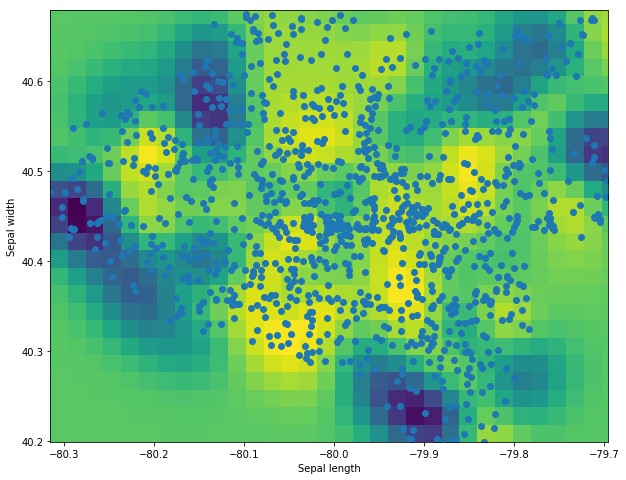

In [183]:
h = .02  # step size in the mesh

X = Data1['Longitude']  # we only take the first two features.
y = Data1['Latitude']

# create a mesh to plot in
x_min, x_max = X.min(), X.max()
y_min, y_max = y.min(), y.max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(10, 10))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(X, y)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

#plt.tight_layout()
plt.show()

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

In [203]:
Data1['est'] = gp.predict(Data1[['Longitude','Latitude']],return_std=True)[0]
Data1['std'] = gp.predict(Data1[['Longitude','Latitude']],return_std=True)[1]

In [208]:
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount,est,std
0,-80.278366,40.468606,-3.977526,-1.594040,0.796953
1,-80.162117,40.384598,-3.854466,-0.800837,0.785295
2,-80.221205,40.366778,-3.833632,-1.246781,0.834106
3,-80.142455,40.622084,-3.698812,-1.251590,0.802157
4,-80.131975,40.544915,-3.580029,-1.326580,0.781547


In [211]:
Data1['outside'] = np.where(abs(Data1['AvgDailyTrafficCount'] - Data1['est']) > Data1['std'] * 2,1,0)

In [219]:
float(len(Data1[Data1['outside'] == 1])) / float(len(Data1))

0.04394618834080718

4% of the sensors are higher or lower than two stndard deviations away from the model prediction.

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)

In [241]:
Data1['categories'] = np.where((Data1['est']  < Data1['AvgDailyTrafficCount']) & (Data1['outside'] == 1),'higher','within')
Data1['categories'] = np.where((Data1['est']  > Data1['AvgDailyTrafficCount']) & (Data1['outside'] == 1),'lower','within')

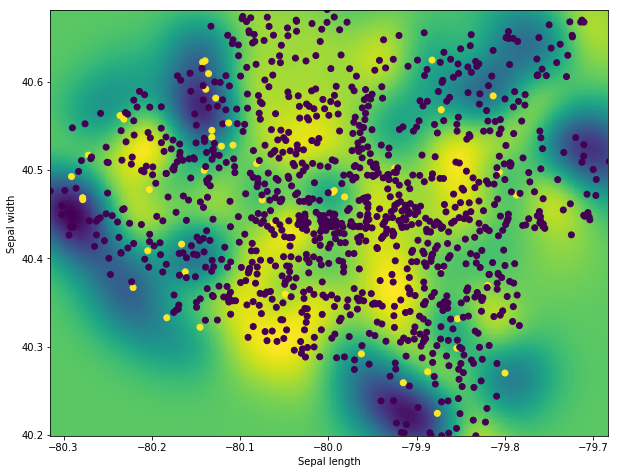

In [245]:
h = .002  # step size in the mesh

X = Data1['Longitude']  # we only take the first two features.
y = Data1['Latitude']

# create a mesh to plot in
x_min, x_max = X.min(), X.max()
y_min, y_max = y.min(), y.max()

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

plt.figure(figsize=(10, 10))
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
plt.subplot(1, 1, 1)
Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape((xx.shape[0], xx.shape[1]))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
plt.scatter(X, y,c=Data1['outside'])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

#plt.tight_layout()
plt.show()

### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


Answer:

(1,0) is an anomoly, as while it is close to the cluster center (0,0) the standard deviation of 0.1 means a point 1 away is quite unlikely. 

(35,2) is not an anomoly, as it is 3 points away from the cluster center (35,5), which is well within the range of a standard deviation of 5. 

(15,19) is an anomoly, the nearby cluster center at (15,20) only has 2 points, meaning very little of the data occurs in this area. 

(10,11) is not an anomoly, as it is near the cluster (10,10) which has 200 points, and is exactly 1 standard deviation away. 

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

In [124]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.iloc[:,1:] = Data2.iloc[:,1:].apply(pd.to_numeric,errors='coerce')
Data2Original = Data2
Data2 = Data2.dropna(axis=0, how='any')
Data2.iloc[:,1:] = Data2.iloc[:,1:].apply(pd.cut,bins=5,labels=False)
Data2.head()

/anaconda3/envs/mlc_env/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",1,2,3,1,1,2,3,3,3,...,1,1,1,1,0,1,3,1,4,2
1,"Baldwin, Alabama",1,2,3,1,1,2,3,2,3,...,1,1,1,1,0,1,3,1,4,2
2,"Barbour, Alabama",2,3,3,2,2,4,2,3,2,...,3,2,3,0,0,1,3,1,4,2
3,"Bibb, Alabama",2,3,3,2,2,4,3,3,1,...,2,1,2,1,0,1,3,1,4,3
4,"Blount, Alabama",1,2,3,1,1,2,4,3,1,...,2,1,1,0,0,1,3,0,4,4


In [125]:
features = Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"]]

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

In [126]:
from pgmpy.estimators import HillClimbSearch,MaximumLikelihoodEstimator,BicScore
from pgmpy.models import BayesianModel


hc = HillClimbSearch(features, scoring_method=BicScore(features))
best_model = hc.estimate()
print(best_model.edges())
model = BayesianModel(best_model.edges())
model.fit(features, estimator=MaximumLikelihoodEstimator)

[("'\\% Children in Poverty'", "'Average Daily PM2.5'"), ("'80/20 Income Ratio'", "'\\% Smokers'"), ("'80/20 Income Ratio'", "'\\% Obese'"), ("'Violent Crime Rate'", "'80/20 Income Ratio'"), ("'\\% Obese'", "'\\% Children in Poverty'")]


(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

In [127]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print thevariable,theparents,theprob
        loglike += np.log(theprob)
    return loglike

exmp=features.apply(lambda x: LL(x,model),axis=1)
print exmp.sort_values().head(5)

1595   -15.172473
126    -15.172473
1126   -13.380713
2348   -13.380713
1123   -13.380713
dtype: float64


In [128]:
print(Data2Original['County'][1595])
print(Data2Original['County'][126])
print(Data2Original['County'][1126])
print(Data2Original['County'][2348])
print(Data2Original['County'][1123])

St. Louis City, Missouri
Crittenden, Arkansas
De Soto, Louisiana
Marlboro, South Carolina
Catahoula, Louisiana


Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

In [129]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.iloc[:,1:] = Data2.iloc[:,1:].apply(pd.to_numeric,errors='coerce')
Data2 = Data2.dropna(axis=0, how='any')
X = Data2.iloc[:,1:]

In [130]:
from sklearn.cluster import KMeans
KM=KMeans(n_clusters=3,random_state=999)
scor=KM.fit_predict(X)

# distance to each cluster center
res=pd.DataFrame(KM.transform(X))
res=pd.concat((res,pd.DataFrame(KM.fit_predict(X))),axis=1)
res.columns=list(range(3))+["cluster"]
res.loc[:,"score"]=res.apply(lambda x: x[int(x["cluster"])],axis=1)

# find data records farthest from cluster centers
res.sort_values("score",ascending=False)[:5]

,0,1,2,cluster,score
1890,2443.716031,1970.018443,2251.260167,1,1970.018443
1294,2036.147297,1332.735955,1759.249198,1,1332.735955
96,1917.732820,1208.900834,1639.063836,1,1208.900834
2304,1644.876605,1017.910163,1394.632068,1,1017.910163
995,1651.954082,918.374430,1366.737248,1,918.374430


In [131]:
print(Data2Original['County'].iloc[1890])
print(Data2Original['County'].iloc[1294])
print(Data2Original['County'].iloc[96])
print(Data2Original['County'].iloc[2304])
print(Data2Original['County'].iloc[995])

Alleghany, North Carolina
Ontonagon, Michigan
Coconino, Arizona
Washington, Pennsylvania
Barren, Kentucky


(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

In [132]:
from sklearn.mixture import GaussianMixture
GM=GaussianMixture(n_components=3,random_state=999)
GM.fit(X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [133]:
# 5 most anomalous data points by log-likelihood (i.e. log probability density)
pd.DataFrame(GM.score_samples(X)).sort_values(0)[:5]

,0
1890,-197.420106
66,-133.042814
1444,-131.452092
2158,-129.450559
1577,-126.696033


In [134]:
print(Data2Original['County'].iloc[1890])
print(Data2Original['County'].iloc[66])
print(Data2Original['County'].iloc[1444])
print(Data2Original['County'].iloc[2158])
print(Data2Original['County'].iloc[1577])

Alleghany, North Carolina
Winston, Alabama
Marion, Mississippi
Harper, Oklahoma
Saline, Missouri


Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

In [92]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(X)
y_pred = clf.predict(X)

In [121]:
clf_results = pd.DataFrame(clf.decision_function(X),clf.predict(X)).reset_index()
clf_results = clf_results.join(Data2['County'])
clf_results[0].sort_values(ascending=True).head()

1890   -0.154351
1164   -0.109960
1577   -0.102183
66     -0.095533
23     -0.092982
Name: 0, dtype: float64

In [135]:
print(Data2Original['County'].iloc[1890])
print(Data2Original['County'].iloc[1164])
print(Data2Original['County'].iloc[1577])
print(Data2Original['County'].iloc[66])
print(Data2Original['County'].iloc[23])

Alleghany, North Carolina
Tensas, Louisiana
Saline, Missouri
Winston, Alabama
Dallas, Alabama


Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

Alleghany, North Carolina is almost always the most anomalous county, while Saline, Missouri, and Winston, Alabama show up multiple times. All the results from the bayesian model do not show up for the other anamoly detection models.